###  Content Analysis News Media Outlets- Inmigration Posts

### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("FB_groups_News_Media_Outlets_immigration.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(9172, 38)

In [5]:
posts['URL']

0       https://www.facebook.com/mundohispanico/posts/...
1       https://www.facebook.com/TELEMUNDOAZ/posts/331...
2       https://www.facebook.com/CNNee/posts/101576804...
3       https://www.facebook.com/CNNee/posts/101577003...
4       https://www.facebook.com/Univision26/posts/101...
                              ...                        
9167    https://www.facebook.com/noticiasunivision.kan...
9168    https://www.facebook.com/TelemundoFortMyersNap...
9169    https://www.facebook.com/TelemundoFresno/posts...
9170    https://www.facebook.com/Lobo97.7FM/posts/3493...
9171    https://www.facebook.com/news.elsol/posts/3693...
Name: URL, Length: 9172, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [6]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [7]:
posts.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'Overperforming Score', 'clean_url', 'State', 'Facebook',
       'MessageDescr', 'MessageOnly'],
      dtype='object')

In [8]:
posts["Created"].head(5)

0    2020-08-28 13:08:24 EDT
1    2020-08-24 18:31:09 EDT
2    2020-08-19 21:27:14 EDT
3    2020-08-27 23:13:13 EDT
4    2020-08-26 19:35:09 EDT
Name: Created, dtype: object

In [9]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0      2020-08-28 13:08:24-04:00
1      2020-08-24 18:31:09-04:00
2      2020-08-19 21:27:14-04:00
3      2020-08-27 23:13:13-04:00
4      2020-08-26 19:35:09-04:00
                  ...           
9167   2020-11-03 08:30:38-05:00
9168   2020-11-03 11:01:44-05:00
9169   2020-11-03 11:01:43-05:00
9170   2020-11-02 18:06:30-05:00
9171   2020-11-03 15:55:22-05:00
Name: converted_date, Length: 9172, dtype: datetime64[ns, tzlocal()]

In [10]:
posts['converted_date'] = posts['converted_date'].dt.date
posts['converted_date'] 

0       2020-08-28
1       2020-08-24
2       2020-08-19
3       2020-08-27
4       2020-08-26
           ...    
9167    2020-11-03
9168    2020-11-03
9169    2020-11-03
9170    2020-11-02
9171    2020-11-03
Name: converted_date, Length: 9172, dtype: object

In [11]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date 

,converted_date,count
0,2020-08-18,108
1,2020-08-19,197
2,2020-08-20,239
3,2020-08-21,118
4,2020-08-22,45
5,2020-08-23,46
6,2020-08-24,81
7,2020-08-25,99
8,2020-08-26,203
9,2020-08-27,149


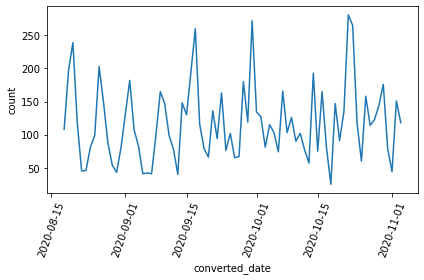

In [12]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [13]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,...,Sponsor Name,Total Interactions,Total Interactions (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x ),Overperforming Score,clean_url,State,Facebook,MessageDescr,MessageOnly,converted_date
2,547,CNN en Español,CNNee,89613772643,13174565.0,2020-08-19 21:27:14 EDT,Link,1767,732,144,...,NaN,"4,272","4,272",10.98,cnnee,Georgia,https://www.facebook.com/CNNee,"Trump: ""La razón por la que estoy aquí es por ...","Trump: ""La razón por la que estoy aquí es por ...",2020-08-19


In [14]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [15]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [16]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

##  Count posts in general by state

In [17]:

df_count = posts.groupby(['State']).agg({'Facebook Id':'count'}).reset_index() 

df_count.columns = ['State','Posts_Counts']
df_count.sort_values(by=['State'], ascending=True,inplace=True)
df_count.fillna(0, inplace=True)
df_count['Posts_Counts'] = df_count['Posts_Counts'].astype(int)
df_count.head(10)



,State,Posts_Counts
0,Alabama,84
1,Alaska,3
2,Arizona,306
3,Arkansas,6
4,California,1406
5,Colorado,176
6,Connecticut,168
7,Delaware,18
8,District of Columbia,308
9,Florida,780


In [18]:
#us_states['State'] = us_states['State']
from functools import reduce
data_frames = [df_count, us_states]
missing_states  = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
missing_states.fillna(0, inplace=True)
missing_states['Posts_Counts'] = missing_states['Posts_Counts'].astype(int)
missing_states

,State,Posts_Counts
0,Alabama,84
1,Alaska,3
2,Arizona,306
3,Arkansas,6
4,California,1406
5,Colorado,176
6,Connecticut,168
7,Delaware,18
8,District of Columbia,308
9,Florida,780


## 3. Which groups are publishing the majority of the content

In [19]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
Impacto Latino,201
NoticiasYa El Paso,183
NoticiasYa Colorado,176
Telemundo Nueva Inglaterra,146
CNN en Espaol,146
Univision,140
NoticiasYa Nevada,140
El Diario de Jurez,137
NoticiasYa El Centro,136


In [20]:


republicans = "donald trump|trump|mike pence|nikki haley|john mccain|susan collins|rand paul|chris christie|\
jeff flake|roger stone|george bush|george w. bush|herbert hoover|charles curtis|sarah palin|bill weld|\
rocky de la fuente|joe walsh|mark sanford|herman cain|brad parscale|melania trump|richard nixon|jared kushner|\
ivanka trump|lindsey graham|newt gingrich|rudy giuliani|william barr|mitch mcconnell|gop|republican|\
republicans|republicano|republicanos"


#democrats
democrats = 'joe biden|biden|hillary clinton|kamala harris|michelle obama|bernie sanders|andrew cuomo|tom pérez|\
harry reid|bill clinton|barack obama|adlai stevenson ii|pete buttigieg|michael bennet|deval patrick|andrew yang|\
amy klobuchar|tom steyer|michael bloomberg|elizabeth warren|tulsi gabbard|geraldine ferraro|tony evers|\
nancy pelosi|josh shapiro|democrat|democrats|democratas|democrata'


general_politics = "kanye west|jo jorgensen|spike cohen|howie hawkins|angela walker|don blankenship|gloria la riva|\
brian t. carroll|brock pierce|phil collins|bill hammons|jerome segal|blake huber|mark charles|dario hunter|\
joseph kishore|alyson kennedy|jade simmons|joe mchugh|kyle kopitke|amy coney barrett|ruth bader ginsburg|\
george floyd|oprah winfrey|breonna taylor|geng shuang|philip goldberg|jho low|chris krebs|chris wallace|\
christopher a. wray|louis dejoy|merrick garland|steve scully|susan page|kristen welker|urszula gacek|\
michael georg link|william h. frey|ann selzer|samuel alito|tucker carlson|cynthia stephens|sidney powell|\
shelby pierson|joseph maguire"



posts_democrats = posts.copy()
posts_democrats = posts[posts['MessageDescr'].str.lower().str.contains(democrats   ,na = False)]
print('democrats', posts_democrats.shape)

posts_republicans = posts.copy()
posts_republicans = posts[posts['MessageDescr'].str.lower().str.contains(republicans   ,na = False)]
print('republicans', posts_republicans.shape)

posts_general_politics = posts.copy()
posts_general_politics = posts[posts['MessageDescr'].str.lower().str.contains(general_politics   ,na = False)]
print('general politics', posts_general_politics.shape)


posts_none = posts.copy()
posts_none = posts[~posts['MessageDescr'].str.lower().str.contains(general_politics + '|' + democrats + '|' +republicans ,na = False)]
print('none',posts_none['MessageDescr'].shape)

posts['Link Text'].isna().sum()

democrats (607, 39)
republicans (2094, 39)
general politics (79, 39)
none (6886,)


871

### 6.Filter Posts per each political party
How much each candidate talked about all the topics that Latinx cared about

In [21]:
posts_democrats['MessageDescr'][3:6]

84     "Este país necesita un nuevo liderazgo": Jill ...
106    U.S. President Donald Trump visited Yuma Tuesd...
136    In case you missed it: The 11-year-old's video...
Name: MessageDescr, dtype: object

In [22]:
posts_democrats.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'Overperforming Score', 'clean_url', 'State', 'Facebook',
       'MessageDescr', 'MessageOnly', 'converted_date'],
      dtype='object')

In [23]:
df_dem = posts_democrats['State'].value_counts().reset_index()
df_dem.columns = ['State','Count']

In [24]:
df_rep = posts_republicans['State'].value_counts().reset_index()
df_rep.columns = ['State','Count']

In [25]:
df_gen_pol = posts_general_politics['State'].value_counts().reset_index()
df_gen_pol.columns = ['State','Count']

In [26]:
df_gen_info = posts_none['State'].value_counts().reset_index()
df_gen_info.columns = ['State','Count']

In [27]:
from functools import reduce
data_frames = [df_dem, df_rep,df_gen_pol,df_gen_info]
df_all = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
df_all.columns = ['State','Posts_Dem','Posts_Rep', 'Posts_Gen_Pol','Post_Gen_Info']
df_all.sort_values(by=['State'], ascending=True,inplace=True)
df_all.fillna(0, inplace=True)
df_all['Posts_Dem'] = df_all['Posts_Dem'].astype(int)
df_all['Posts_Rep'] = df_all['Posts_Rep'].astype(int)
df_all['Posts_Gen_Pol'] = df_all['Posts_Gen_Pol'].astype(int)
df_all['Post_Gen_Info'] = df_all['Post_Gen_Info'].astype(int)
df_all

,State,Posts_Dem,Posts_Rep,Posts_Gen_Pol,Post_Gen_Info
6,Alabama,25,45,2,37
42,Alaska,0,0,0,3
8,Arizona,23,88,2,213
40,Arkansas,0,2,0,4
0,California,94,365,12,1014
17,Colorado,10,36,1,137
15,Connecticut,11,37,1,127
41,Delaware,0,0,0,18
12,District of Columbia,16,60,2,242
2,Florida,51,179,8,581


In [28]:
dummy = posts_democrats[posts_democrats['MessageDescr'].str.contains("gop")]
pd.set_option('display.max_colwidth', 400)
dummy['MessageDescr']

Series([], Name: MessageDescr, dtype: object)

## FB Groups Political Posts

In [29]:
posts_political =  pd.concat([posts_democrats,posts_republicans,posts_general_politics])

#posts_political = df_posts_state[df_posts_state['MessageDescr'].str.lower().str.contains(democrats + '|' +republicans+ '|' +general_politics, na = False)]
df_political = posts_political['State'].value_counts().reset_index()
df_political.columns = ['State','Count']
df_political

,State,Count
0,California,471
1,Texas,391
2,Florida,238
3,New York,218
4,Georgia,125
5,Puerto Rico,122
6,Arizona,113
7,Massachusetts,91
8,North Carolina,89
9,District of Columbia,78


## Tokenize words and Clean-up text

In [30]:
content = posts.copy()
content['MessageDescr'].head()

0                                                LE CAYÓ ICE: Este hondureño estaba pintando cuando lo bajaron de escalera los agentes federales y él es uno de tantos en esa lista negra que tiene inmigración: https://bit.ly/31zrUtN:=:https://mundohispanico.com/cronica-inmigracion-tras-pervertidos/ Mario Guevara https://www.facebook.com/MarioGuevaraNews/photos/a.626937290707062/3339596216107809/?type=3
1    Nunca antes visto: la gente ha tenido que dormir en sus autos y hay quienes ofrecen una cubeta por $2.50 para los que necesitan ir al baño. https://trib.al/mhKM8Xu:=:https://www.telemundoarizona.com/noticias/inmigracion/largas-filas-de-hasta-10-horas-en-tijuana-para-cruzar-a-san-diego/2091448/ Estos cierres han implicado que las filas en las fronteras sean de un tamaño nunca antes visto y con ...
2    Trump: "La razón por la que estoy aquí es por el presidente Obama y Joe Biden, porque si ellos hubieran hecho un buen trabajo, yo no estaría aquí" https://cnn.it/3l0lHyK:=:https://cnnes

In [31]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(9172,)

In [32]:
# Convert to list
data = content.cleanMessage.tolist()

In [33]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [34]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['le', 'cayo', 'ice', 'este', 'hondureno', 'estaba', 'pintando', 'cuando', 'lo', 'bajaron', 'de', 'escalera', 'los', 'agentes', 'federales', 'el', 'es', 'uno', 'de', 'tantos', 'en', 'esa', 'lista', 'negra', 'que', 'tiene', 'inmigracion'], ['nunca', 'antes', 'visto', 'la', 'gente', 'ha', 'tenido', 'que', 'dormir', 'en', 'sus', 'autos', 'hay', 'quienes', 'ofrecen', 'una', 'cubeta', 'por', 'para', 'los', 'que', 'necesitan', 'ir', 'al', 'bano']]


#### Creating Bigram and Trigram Models

In [35]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['le', 'cayo', 'ice', 'este', 'hondureno', 'estaba', 'pintando', 'cuando', 'lo', 'bajaron', 'de', 'escalera', 'los', 'agentes', 'federales', 'el', 'es', 'uno', 'de', 'tantos', 'en', 'esa', 'lista', 'negra', 'que', 'tiene', 'inmigracion']


## Remove Stopwords, Make Bigrams and Lemmatize

In [36]:
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [37]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [43]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download en_core_news_sm
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [44]:
print(data_words_nostops[1:2])

[['nunca', 'visto', 'gente', 'dormir', 'autos', 'ofrecen', 'cubeta', 'necesitan', 'ir', 'bano']]


## Bag of Words

In [45]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [46]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [47]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [48]:
final_dict.most_common(1000)

[('inmigrante', 2425),
 ('frontero', 2329),
 ('donald / trump', 2123),
 ('indocumentado', 1958),
 ('mexico', 1654),
 ('personar', 1076),
 ('ano', 965),
 ('migrante', 925),
 ('agente', 878),
 ('president / presidente', 819),
 ('nuevo', 805),
 ('decir', 802),
 ('covid / coronavirus', 766),
 ('ninos', 717),
 ('federal', 621),
 ('hacer', 597),
 ('unir', 538),
 ('detalle', 533),
 ('partir', 509),
 ('pasar', 503),
 ('caso', 495),
 ('llegar', 491),
 ('abogar', 489),
 ('poder', 485),
 ('arrestar', 476),
 ('centrar', 475),
 ('dar', 474),
 ('ee_uu', 466),
 ('politica', 460),
 ('inmigracion', 459),
 ('detenido', 459),
 ('anunciar', 452),
 ('ahora', 451),
 ('familia', 448),
 ('contar', 437),
 ('octubre', 431),
 ('murar', 430),
 ('mexicano', 427),
 ('autoridad', 426),
 ('trabajar', 417),
 ('ciudad', 415),
 ('hoy', 405),
 ('pandemia', 401),
 ('ayudar', 400),
 ('operativo', 391),
 ('mujer', 391),
 ('post', 388),
 ('padre', 380),
 ('noticiar', 379),
 ('casar', 378),
 ('redar', 376),
 ('detener', 366),

In [49]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [50]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
#print(bow_df)

In [51]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [52]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
frontero,2.599458
inmigrante,2.776076
trump,2.822197
indocumentado,2.939391
mexico,3.095818
personar,3.485452
ano,3.580108
presidente,3.642443
decir,3.717140
agente,3.730429


In [53]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [54]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv("outlets_tfidf.csv")

In [55]:
df

,tfidf
agente,0.220874
bajar,0.419168
escalera,0.469336
federal,0.242647
listo,0.326175
negro,0.425094
pintar,0.457454


In [56]:
word = df.index[1]
content["lowercase"] = content['cleanMessage'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')
word_messages.to_csv(word + "_messages.csv")
word_messages

,unique_messages,counts
0,"vicente, hispano y trabajador del campo, participó de una sesión ante congresistas del subcomité de ciudadanía e inmigración en la cámara de representantes para abogar por la legalización de los campesinos indocumentados. nacido en méxico y traído a los seis años de edad, vicente se ha convertido poco a poco en un activista que aboga por la legalización de los campesinos indocumentados. y es q...",3
1,"alerta padres: esta madre latina salió a trabajar y dejó sus niños solos, pero le pusieron el dedo y ahora están desamparados y hasta ice se metió. detalles:",2
2,algunas personas decidieron no salir a trabajar por temor a ser detenidos por supuestos agentes de #ice #maryland algunas personas decidieron no salir a trabajar por temor a ser detenidos por supuestos agentes de ice supuesta redada de ice paralizó un sector de hyattsville,2
3,"el noreste de colorado, el sureste de wyoming y el panhandle de nebraska estaban en una advertencia de congelamiento hasta el miércoles por la mañana. sidney, ne - el verano llegó a un abrupto final en el panhandle de nebraska cuando las temperaturas bajaron casi 40 grados en menos de 24 horas. una poderosa oleada de aire frío procedente de canadá desató la nieve y las temperaturas bajo cero e...",2
4,"“son un poco más de 109.000 los migrantes que han regresado a venezuela durante la pandemia"" afirmó el director de migración colombia, juan francisco espinosa palacios “son un poco más de 109.000 los migrantes que han regresado a venezuela durante la pandemia\"" afirmó el director de migración colombia, juan francisco espinosa palacios migración colombia asegura que tras activación económica em...",2
5,"varios intentos de contrabando humano fueron interrumpidos por agentes de la patrulla fronteriza esta semana, logrando un total de 50 arrestos de inmigrantes indocumentados. agentes de la patrulla fronteriza y tropas del departamento de seguridad pública de texas (dps) trabajaron en conjunto para interrumpir una importante operación de contrabando de personas en missio… detienen intento de con...",1
6,"durante su visita al sur de florida, el candidato de demócrata aseveró que no suavizaría las sanciones en contra de los regímenes socialistas, se comprometió a trabajar en una reforma migratoria y en un tps para los venezolanos. durante su visita al sur de florida, el candidato de demócrata aseveró que no suavizaría las sanciones en contra de los regímenes socialistas, se comprometió a trabaja...",1
7,"nuevamente en campaña, ahora por la reelección, trump se comprometió de nuevo a hacer que méxico pague por el muro, al cobrar peaje a las personas que ingresan a estados unidos desde méxico. la comunidad fronteriza que cruza en promedio diario la frontera de tijuana a california para trabajar, tomó con prudencia la idea del presidente donald trump. donald trump: cobrar la entrada a ee.uu. para...",1
8,"""blood on the wall"", la sombra de ee.uu. en el camino de los migrantes (efe news).- tras cada paso de un migrante latino está la sombra de estados unidos. esa es la tesis de ""blood on the wall"", documental de national geographic que explora cómo la política estadounidense contribuyó a desestabilizar méxico y américa central y forzó a miles de personas a abandonar su hogar por la violencia del ...",1
9,"𝐋𝐨𝐬 𝐥𝐚𝐭𝐢𝐧𝐨𝐬, 𝐝𝐢𝐯𝐢𝐝𝐢𝐝𝐨𝐬, 𝐩𝐞𝐫𝐨 𝐧𝐨 𝐩𝐨𝐫 𝐢𝐠𝐮𝐚𝐥 miami/los ángeles, 29 oct (efe news).- sin inmunidad contra la polarización reinante, los latinos llegan divididos a las elecciones, aunque no a partes iguales: al menos en los sondeos son más los que apoyan al demócrata joe biden que a un presidente donald trump que les reparte indistintamente cal y arena. en una comunidad de unos 60 millones de perso...",1


### Repeated messages

In [57]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

results.to_csv("mostpopularNewsMedia.csv")

In [58]:
results.sort_values(by='Total Interactions',ascending=False).head(20)

,,Counts,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,Total Interactions
MessageDescr,Link,,,,,,,,,,,
"ALERTA PADRES: Esta madre latina salió a trabajar y dejó sus niños solos, pero le pusieron el dedo y ahora están desamparados y hasta ICE se metió. DETALLES: https://bit.ly/2QqRkDx:=:https://mundohispanico.com/cronica-madre-latina-dejo-sus-ninos-solos-en-el-hotel/ Mario Guevara https://www.facebook.com/MarioGuevaraNews/photos/a.626937290707062/3333056563428441/?type=3",https://www.facebook.com/MarioGuevaraNews/photos/a.626937290707062/3333056563428441/?type=3,1,3533,3446,4096,39,1339,12,4936,2519,14,19934
LE CAYÓ ICE: Este hondureño estaba pintando cuando lo bajaron de escalera los agentes federales y él es uno de tantos en esa lista negra que tiene inmigración: https://bit.ly/31zrUtN:=:https://mundohispanico.com/cronica-inmigracion-tras-pervertidos/ Mario Guevara https://www.facebook.com/MarioGuevaraNews/photos/a.626937290707062/3339596216107809/?type=3,https://www.facebook.com/MarioGuevaraNews/photos/a.626937290707062/3339596216107809/?type=3,1,3034,2975,1536,50,789,54,5350,2719,13,16520
"ALERTA PADRES: Esta madre latina salió a trabajar y dejó sus niños solos, pero le pusieron el dedo y ahora están desamparados y hasta ICE se metió. DETALLES: https://bit.ly/2QqRkDx:=:https://mundohispanico.com/cronica-madre-latina-dejo-sus-ninos-solos-en-el-hotel/ Mario Guevara https://www.facebook.com/MarioGuevaraNews/photos/a.626937290707062/3333413993392698/?type=3",https://www.facebook.com/MarioGuevaraNews/photos/a.626937290707062/3333413993392698/?type=3,1,1947,2541,1755,18,894,15,4443,392,15,12020
"Una ballena jorobada quedó varada en un río infestado de cocodrilos en Australia, después de confundirse durante la migración, según expertos. https://cnn.it/3ixda4t:=:https://cnnespanol.cnn.com/2020/09/14/una-ballena-jorobada-queda-varada-en-un-rio-infestado-de-cocodrilos/ Una ballena jorobada quedó varada en un río infestado de cocodrilos en Australia, después de aparentemente confundirse durante la migración Ballena jorobada queda atrapada en río de infestado de cocodrilos https://cnn.it/3ixda4t",https://cnn.it/3ixda4t,1,6021,71,231,40,1267,34,3032,16,13,10725
"🔴 Alcalde pide la restricción para ingresos de norteamericanos a #México para actividades no esenciales ⤵️ El Ayuntamiento formalizará la petición a la SRE para que negocie con el gobierno norteamericano, dijo el alcalde Armando Cabada Pide Cabada CERRAR FRONTERA a estadounidenses https://diario.mx/juarez/solicitara-municipio-impedir-el-paso-de-estadounidenses-a-mexico-20201019-1721071.html",https://diario.mx/juarez/solicitara-municipio-impedir-el-paso-de-estadounidenses-a-mexico-20201019-1721071.html,1,5864,1343,970,1140,232,857,22,37,33,10498
"Él es Roberto Castillo Gutiérrez, un salvadoreño de 33 años que fue arrestado en Georgia por manejar sin licencia. Cometió el error de pasarse sobre la línea amarilla, una infracción de tránsito conocida como “failure to maintain lane” y como no contaba con una licencia válida del estado lo entregaron con ICE para que lo deporte. Recuerden mis amigos si manejan traten de respetar al máximo el reglamento vial porque acá las autoridades son muy severas. Mario Guevara https://www.facebook.com/MarioGuevaraNews/photos/a.626937290707062/3467532699980826/?type=3",https://www.facebook.com/MarioGuevaraNews/photos/a.626937290707062/3467532699980826/?type=3,1,2479,3658,1043,17,766,130,1330,121,11,9555
#CrónicasDelTaco narra la experiencia de comer burritos en la frontera en el quinto episodio de su segunda temporada en Netflix 🌮🌯 Crónicas del Taco narra la experiencia de comer burritos en la frontera en el quinto episodio de su segunda temporada en Netflix Burritos juarenses llegan a serie de Netflix https://diario.mx/espectaculos/envueltos-de-fama-20200916-1709185.html,https://diario.mx/espectaculos/envueltos-de-fama-20200916-1709185.html,1,3677,1003,1430,2301,525,155,2,4,88,9185
"La decisión 2-1 pone en riesgo de deportación a unos 300,000 i

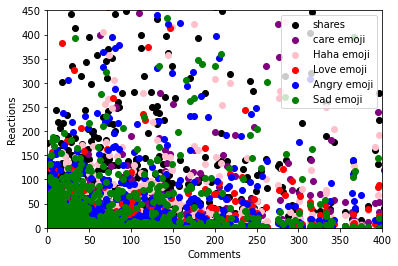

In [59]:
results.reset_index()
plt.xlim(0,400)
plt.ylim(0,450)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


In [60]:
#Topic Modeling
#Create the Dictionary and Corpus needed for Topic Modeling


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]
[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]
#Buiding the Topic Model



[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]

In [61]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [62]:
#View the topics in LDA model
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.155*"ingle" + 0.128*"legal" + 0.126*"medir" + 0.100*"publicar" + '
  '0.079*"sigla" + 0.066*"seguir" + 0.038*"mantener" + 0.016*"cargar" + '
  '0.014*"registrar" + 0.013*"control"'),
 (1,
  '0.112*"tambien" + 0.094*"juez" + 0.070*"ola" + 0.067*"alertar" + '
  '0.063*"pais" + 0.053*"millón" + 0.044*"total" + 0.040*"dirigir" + '
  '0.026*"noche" + 0.024*"combatir"'),
 (2,
  '0.264*"detalle" + 0.150*"contar" + 0.144*"inmigracion" + 0.093*"migratorio" '
  '+ 0.059*"trabajar" + 0.038*"documento" + 0.032*"recibir" + 0.028*"decena" + '
  '0.023*"afectar" + 0.008*"permiso"'),
 (3,
  '0.114*"noticiar" + 0.076*"acercar" + 0.072*"pasar" + 0.067*"pandemia" + '
  '0.067*"juntar" + 0.043*"jueves" + 0.042*"papel" + 0.042*"viernes" + '
  '0.039*"importante" + 0.036*"formar"'),
 (4,
  '0.212*"personar" + 0.122*"asilar" + 0.081*"serio" + 0.063*"dar" + '
  '0.058*"derecho" + 0.056*"esposar" + 0.046*"hablar" + 0.037*"centro" + '
  '0.032*"vida" + 0.031*"segundar"'),
 (5,
  '0.387*"federal" + 0.1

In [63]:
#Compute Model Perplexity and Coherence Score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.163580250600177

Coherence Score:  0.3685533512482328


In [64]:
#Visualize the topics-keywords
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.294224 -0.334060       1        1  18.716488
14     0.307406  0.319956       2        1  11.828455
7     -0.016308  0.001097       3        1   7.190481
19     0.065745  0.001113       4        1   6.545888
4      0.057637  0.001060       5        1   6.009007
3      0.020158  0.001209       6        1   5.945016
13     0.054297  0.001018       7        1   5.671515
2      0.016832  0.001067       8        1   4.326769
8     -0.033268  0.001043       9        1   4.255234
11    -0.005126  0.001113      10        1   4.069132
16     0.060661  0.000978      11        1   4.024693
0     -0.047940  0.000966      12        1   3.616206
6     -0.017481  0.001006      13        1   2.908563
1     -0.102784  0.000494      14        1   2.728940
12    -0.085943  0.000674      15        1   2.529506
10    -0.129256 -0.000074      16        1   2.074126
17    -0.126028  0.000032      17        1   1.969881
5     -0.096370  0.000527      18        1   1.925934
15    -0.115078  0.000277      19        1   1.885735
9     -0.101378  0.000505      20        1   1.778437, topic_info=                             Term         Freq        Total Category  logprob  \
194                    inmigrante  7230.000000  7230.000000  Default  30.0000   
28                          trump  3907.000000  3907.000000  Default  29.0000   
0                          agente  2380.000000  2380.000000  Default  28.0000   
65                  indocumentado  3958.000000  3958.000000  Default  27.0000   
29                            ano  2643.000000  2643.000000  Default  26.0000   
204                       centrar  2108.000000  2108.000000  Default  25.0000   
265                       detalle  1849.000000  1849.000000  Default  24.0000   
367                      personar  2057.000000  2057.000000  Default  23.0000   
26                          nuevo  1980.000000  1980.000000  Default  22.0000   
421                      detenido  1656.000000  1656.000000  Default  21.0000   
524                      deportar  2938.000000  2938.000000  Default  20.0000   
416                      arrestar  1498.000000  1498.000000  Default  19.0000   
3                         federal  1204.000000  1204.000000  Default  18.0000   
227                         decir  2793.000000  2793.000000  Default  17.0000   
511                         ninos  1266.000000  1266.000000  Default  16.0000   
604                         poder  1208.000000  1208.000000  Default  15.0000   
17                     presidente  1381.000000  1381.000000  Default  14.0000   
16                          hacer   949.000000   949.000000  Default  13.0000   
657                         casar  1236.000000  1236.000000  Default  12.0000   
522                        asilar  1183.000000  1183.000000  Default  11.0000   
374                        contar  1051.000000  1051.000000  Default  10.0000   
81                           caso   843.000000   843.000000  Default   9.0000   
193                   inmigracion  1005.000000  1005.000000  Default   8.0000   
453                      noticiar  1100.000000  1100.000000  Default   7.0000   
201                         dejar   959.000000   959.000000  Default   6.0000   
130                         ingle   905.000000   905.000000  Default   5.0000   
25                       nacional   736.000000   736.000000  Default   4.0000   
470                        ciudad  1773.000000  1773.000000  Default   3.0000   
267                        partir  1691.000000  1691.000000  Default   2.0000   
276                      elección   751.000000   751.000000  Default   1.0000   
524                      deportar  2936.018555  2938.192383   Topic1  -2.3319   
227                         decir  2791.352295  2793.526123   Topic1  -2.3825   
470                        ciudad  1771.286255  1773.460571   Topic1  -2.8373   
267            

## Building LDA Mallet Model

In [65]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [66]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('frontero', 0.15329606033025614),
   ('mexico', 0.07749317383955272),
   ('ee_uu', 0.06059030035105968),
   ('octubre', 0.05603952671954232),
   ('post', 0.050448576257963854),
   ('viaje', 0.03458587959953192),
   ('cerrar', 0.032115459628136785),
   ('esencial', 0.027954752307892343),
   ('explicar', 0.026914575477831233),
   ('permitir', 0.02483422181770901)]),
 (4,
  [('votar', 0.03501900702684022),
   ('elección', 0.03363667780209653),
   ('temer', 0.025112314249510426),
   ('poder', 0.02292362631033291),
   ('latino', 0.022578044004146987),
   ('hispano', 0.01405368045156088),
   ('resultar', 0.013938486349498905),
   ('hacer', 0.01301693353300311),
   ('millón', 0.011749798410321392),
   ('decir', 0.011749798410321392)]),
 (5,
  [('partir', 0.02414618229279965),
   ('comunidad', 0.016423754622579945),
   ('formar', 0.014248422884489884),
   ('tiempo', 0.014139656297585382),
   ('publicar', 0.013595823363062868),
   ('manera', 0.01185555797259082),
   ('querer', 0.01120

## Finding the optimal number of topics for LDA

In [67]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [68]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=22, step=2)

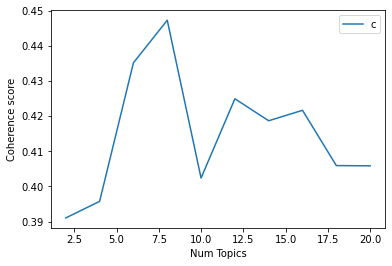

In [69]:
# Show graph
limit=22; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [70]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.391
Num Topics = 4  has Coherence Value of 0.3957
Num Topics = 6  has Coherence Value of 0.4352
Num Topics = 8  has Coherence Value of 0.4474
Num Topics = 10  has Coherence Value of 0.4024
Num Topics = 12  has Coherence Value of 0.425
Num Topics = 14  has Coherence Value of 0.4187
Num Topics = 16  has Coherence Value of 0.4217
Num Topics = 18  has Coherence Value of 0.4059
Num Topics = 20  has Coherence Value of 0.4059


In [71]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.029*"detalle" + 0.027*"caso" + 0.027*"abogar" + 0.025*"inmigracion" + '
  '0.022*"hoy" + 0.021*"noticiar" + 0.021*"casar" + 0.020*"dar" + '
  '0.020*"coronavirus" + 0.019*"hacer"'),
 (1,
  '0.109*"trump" + 0.042*"presidente" + 0.022*"murar" + 0.019*"indocumentado" '
  '+ 0.016*"juez" + 0.016*"votar" + 0.015*"pagar" + 0.015*"elección" + '
  '0.015*"temer" + 0.015*"migratorio"'),
 (2,
  '0.039*"nuevo" + 0.022*"pasar" + 0.022*"anunciar" + 0.021*"octubre" + '
  '0.017*"aumentar" + 0.015*"coronavirus" + 0.012*"servicio" + 0.011*"semana" '
  '+ 0.010*"venezolano" + 0.010*"iniciar"'),
 (3,
  '0.019*"decir" + 0.013*"ciudad" + 0.012*"hijo" + 0.012*"partir" + '
  '0.011*"tambien" + 0.011*"hacer" + 0.010*"poder" + 0.009*"vida" + '
  '0.008*"dejar" + 0.008*"solo"'),
 (4,
  '0.058*"inmigrante" + 0.042*"ano" + 0.025*"centrar" + 0.021*"personar" + '
  '0.021*"mujer" + 0.015*"deportar" + 0.015*"detenido" + 0.014*"grupo" + '
  '0.013*"viernes" + 0.013*"hombre"'),
 (5,
  '0.079*"indocumentado"

## Finding the dominant topic in each sentence

In [72]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.1623,"decir, ciudad, hijo, partir, tambien, hacer, poder, vida, dejar, solo",LE CAYÓ ICE: Este hondureño estaba pintando cuando lo bajaron de escalera los agentes federales y él es uno de tantos en esa lista negra que tiene inmigración:
1,1,0.0,0.2071,"detalle, caso, abogar, inmigracion, hoy, noticiar, casar, dar, coronavirus, hacer",Nunca antes visto: la gente ha tenido que dormir en sus autos y hay quienes ofrecen una cubeta por $2.50 para los que necesitan ir al baño.
2,2,3.0,0.1379,"decir, ciudad, hijo, partir, tambien, hacer, poder, vida, dejar, solo","Trump: ""La razón por la que estoy aquí es por el presidente Obama y Joe Biden, porque si ellos hubieran hecho un buen trabajo, yo no estaría aquí"""
3,3,3.0,0.1425,"decir, ciudad, hijo, partir, tambien, hacer, poder, vida, dejar, solo","Trump: ""Vamos a dirigir este país hacia nuevas fronteras de ambición, descubrimiento y alcanzar nuevas alturas de logros nacionales”"
4,4,3.0,0.2112,"decir, ciudad, hijo, partir, tambien, hacer, poder, vida, dejar, solo",La jirafa Modesto del Parque Central de Ciudad Juárez cumplió este día 20 años de vida y fue festejado con pastel de zanahorias y verduras. Él llegó a Juárez con solo un año de edad ya cumplió 19 años en esta frontera convirtiéndose en un icono de las familias juarenses. Feliz cumpleaños a Modesto
5,5,2.0,0.1627,"nuevo, pasar, anunciar, octubre, aumentar, coronavirus, servicio, semana, venezolano, iniciar",Esto sería una alternativa para disminuir contagios de #Covid_19: OMPP Esto sería una alternativa para disminuir contagios de Covid-19: OMPP ‘México debería cerrar fronteras con EU’
6,6,1.0,0.1500,"trump, presidente, murar, indocumentado, juez, votar, pagar, elección, temer, migratorio","White supremacy was behind child separations — and Trump officials went along, critics say. An NBC News report that White House senior adviser Stephen Miller asked top administration officials and cabinet members to raise their hands and approve child separations— because not enforcing strict immigration policy would be ""the end of our country as we know it""—is a ""damning display of white supr..."
7,7,0.0,0.1601,"detalle, caso, abogar, inmigracion, hoy, noticiar, casar, dar, coronavirus, hacer",¿Nunca te llegó tu sobre de inmigración? Esta empleada postal ahora enfrenta cargos por destrucción ilegal de cartas.
8,8,0.0,0.1641,"detalle, caso, abogar, inmigracion, hoy, noticiar, casar, dar, coronavirus, hacer",¿Nunca te llegó tu sobre de inmigración? Esta empleada postal ahora enfrenta cargos por destrucción ilegal de cartas.
9,9,3.0,0.1623,"decir, ciudad, hijo, partir, tambien, hacer, poder, vida, dejar, solo",LE CAYÓ ICE: Este hondureño estaba pintando cuando lo bajaron de la escalera los agentes federales y él es uno de tantos en esa lista negra de inmigración:


## Find the most representative document for each topic


In [73]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4840,"detalle, caso, abogar, inmigracion, hoy, noticiar, casar, dar, coronavirus, hacer",USCIS Proporcionará Intérpretes por Contrato para Entrevistas de Asilo La Regla Provisional Ayuda a Evitar la Propagacion de COVID-19 WASHINGTON—El Servicio de Ciudadanía e Inmigración de Estados Unidos anunció hoy una regla final provisional para ayudar a evitar la propagación del coronavirus (COVID-19) mediante el uso de intérpretes telefónicos contratados por el gobierno para entrevistas af...
1,1.0,0.4489,"trump, presidente, murar, indocumentado, juez, votar, pagar, elección, temer, migratorio","El candidato presidencial demócrata, Joe Biden, se ha comprometido a revertir la política migratoria de Donald Trump, si gana la Casa Blanca en las elecciones de noviembre. Pero, ¿de verdad puede hacerlo? “No creo que sea realista que Biden en cuatro años pueda deshacer todo lo que hizo Trump”, dijo a NPR Sarah Pierce, analista política en Migration Policy Institute. [ 429 more words ] http://..."
2,2.0,0.6090,"nuevo, pasar, anunciar, octubre, aumentar, coronavirus, servicio, semana, venezolano, iniciar","Primeros pasos hacia la reapertura de la actividad turística en Centroamérica y el Caribe Por Redacción LA VOZ Los países de Centroamérica y el Caribe han dado a conocer sus primeros pasos hacia la reapertura de la actividad turística. Para ello, han ideado un plan de reactivación basado en la recuperación de la conectividad aérea, así como en el establecimiento de unos protocolos de bioseguri..."
3,3.0,0.5679,"decir, ciudad, hijo, partir, tambien, hacer, poder, vida, dejar, solo","Hoy, los amigos de Mamás y Mujeres Latinas en Ohio estarán compartiendo un gran encuentro con nuestro CEO Wilder M Gomez en un...Café con Libros. Estarán hablando sobre su primer libro “Una locura alrededor del mundo” Te esperamos !!! #columbus #ohio #wildermgomez #libro #autor #escritor #cafeconlibros #mamasymujereslatinas #bestseller Este sábado en nuestro evento virtual Café con Libros, ten..."
4,4.0,0.4327,"inmigrante, ano, centrar, personar, mujer, deportar, detenido, grupo, viernes, hombre","José Marín Soriano, de 59 años, es señalado de agredir sexualmente a una mujer, encadenarla a una cama y disparar contra otra mujer que fue hallada muerta dentro de un automóvil calcinado. Los investigadores recibieron pistas fiables que indican que el hombre cruzó la frontera hacia el país azteca. José Marín Soriano, de 59 años, es señalado de agredir sexualmente a una mujer, encadenarla a un..."
5,5.0,0.4658,"indocumentado, inmigrante, agente, personar, federal, arrestar, operativo, redar, detener, autoridad","El Servicio de Control de Inmigración y Aduanas, ICE por sus siglas en inglés, informó que ejecutó una redada en el centro y sur de Texas que resultó en el arresto de 125 inmigrantes indocumentados. El operativo, según la agencia, tenía el propósito de arrestar a individuos indocumentados con antecedentes penales. La redada se realizó entre el 13 de julio y el 20 de agosto. [ 173 more words ] ..."
6,6.0,0.5998,"frontero, mexico, migrante, ee_uu, llegar, post, cruzar, ahora, esperar, fronterizo","Las tormentas tropicales Laura y Marco siguen en camino hacia el Golfo la próxima semana Hoy 7:20 AM Satélite tropical del sábado por la mañana Hay dos tormentas tropicales, Laura y Marco, que se prevé que se dirijan al Golfo de México en los próximos días. Se espera que ambas tormentas azoten Estados Unidos continental la próxima semana. El Centro Nacional de Huracanes el sábado continuó rast..."
7,7.0,0.5873,"ninos, unir, familia, trabajar, ayudar, padre, pandemia, migrante, legal, politica","This will be an online event! No se lo pierdan! PerformancerUS will be presenting, Performing Ourselves, Performing our Histories, a series of poems, monologues, and dialogues inspired by the Oral Narratives of Latin@ in Ohio (ONLO) archive, and each of the ensemble members personal and collective stories. This performance piece eng

In [74]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [75]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,3.0,"decir, ciudad, hijo, partir, tambien, hacer, poder, vida, dejar, solo",1552.0,0.1692
1.0,0.0,"detalle, caso, abogar, inmigracion, hoy, noticiar, casar, dar, coronavirus, hacer",1300.0,0.1417
2.0,3.0,"decir, ciudad, hijo, partir, tambien, hacer, poder, vida, dejar, solo",1069.0,0.1166
3.0,3.0,"decir, ciudad, hijo, partir, tambien, hacer, poder, vida, dejar, solo",861.0,0.0939
4.0,3.0,"decir, ciudad, hijo, partir, tambien, hacer, poder, vida, dejar, solo",1146.0,0.1249
5.0,2.0,"nuevo, pasar, anunciar, octubre, aumentar, coronavirus, servicio, semana, venezolano, iniciar",1200.0,0.1308
6.0,1.0,"trump, presidente, murar, indocumentado, juez, votar, pagar, elección, temer, migratorio",1050.0,0.1145
7.0,0.0,"detalle, caso, abogar, inmigracion, hoy, noticiar, casar, dar, coronavirus, hacer",994.0,0.1084
